<a href="https://colab.research.google.com/github/sowmyagorrepati/stroke-identification/blob/main/capstone_stroke_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Details**

In [12]:
# Install kagglehub
!pip install kagglehub --quiet

import kagglehub

# Download the Brain Stroke CT dataset
path = kagglehub.dataset_download("ozguraslank/brain-stroke-ct-dataset")

print("✅ Dataset downloaded to:", path)

# Let's check the contents
import os

for root, dirs, files in os.walk(path):
    print("Root:", root)
    print("Dirs:", dirs)
    print("Files:", files[:5])  # show first 5 files
    print("-" * 50)


Using Colab cache for faster access to the 'brain-stroke-ct-dataset' dataset.
✅ Dataset downloaded to: /kaggle/input/brain-stroke-ct-dataset
Root: /kaggle/input/brain-stroke-ct-dataset
Dirs: ['Brain_Stroke_CT_Dataset']
Files: []
--------------------------------------------------
Root: /kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset
Dirs: ['Ischemia', 'Bleeding', 'Normal', 'External_Test']
Files: []
--------------------------------------------------
Root: /kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Ischemia
Dirs: ['DICOM', 'OVERLAY', 'PNG']
Files: []
--------------------------------------------------
Root: /kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Ischemia/DICOM
Dirs: []
Files: ['15633.dcm', '12070.dcm', '14644.dcm', '11624.dcm', '15278.dcm']
--------------------------------------------------
Root: /kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Ischemia/OVERLAY
Dirs: []
Files: ['14127.png', '14325.png', '15055.png', '101

Binary classification

In [13]:
# === Imports ===
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# === Dataset path ===
dataset_path = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset"

# === Load images ===
data = []
labels = []

# We'll treat Ischemia + Bleeding = 'Stroke', Normal = 'Normal'
class_map = {'Normal':'Normal', 'Ischemia':'Stroke', 'Bleeding':'Stroke'}

for cls_folder, label in class_map.items():
    folder_path = os.path.join(dataset_path, cls_folder, 'PNG')
    for file in os.listdir(folder_path):
        if file.endswith('.png'):
            img_path = os.path.join(folder_path, file)
            img = load_img(img_path, target_size=(128,128))
            arr = img_to_array(img)/255.0
            data.append(arr)
            labels.append(label)

print("Total images loaded:", len(data))

# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  # Normal=0, Stroke=1

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# === Classical ML requires flat features ===
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# --- Train classical ML models ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

acc_dict = {}
cm_dict = {}

for name, model in models.items():
    model.fit(X_train_flat, y_train)
    y_pred = model.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    acc_dict[name] = acc
    cm_dict[name] = confusion_matrix(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

# --- CNN Model ---
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=10, batch_size=32, verbose=1)

cnn_acc = cnn.evaluate(X_test, y_test, verbose=0)[1]
acc_dict['CNN'] = cnn_acc
y_pred_cnn = (cnn.predict(X_test) > 0.5).astype(int)
cm_dict['CNN'] = confusion_matrix(y_test, y_pred_cnn)

# --- Print CNN Accuracy ---
print(f"CNN Accuracy: {cnn_acc*100:.2f}%")


Total images loaded: 6650
Logistic Regression Accuracy: 0.8594
SVM Accuracy: 0.8789
KNN Accuracy: 0.8526
Random Forest Accuracy: 0.8459


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 129s 762ms/step - accuracy: 0.6849 - loss: 0.6410 - val_accuracy: 0.8459 - val_loss: 0.3930
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 142s 767ms/step - accuracy: 0.8288 - loss: 0.3770 - val_accuracy: 0.8910 - val_loss: 0.2733
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 131s 786ms/step - accuracy: 0.9100 - loss: 0.2207 - val_accuracy: 0.9165 - val_loss: 0.2188
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 141s 782ms/step - accuracy: 0.9553 - loss: 0.1258 - val_accuracy: 0.9271 - val_loss: 0.1834
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 140s 769ms/step - accuracy: 0.9761 - loss: 0.0781 - val_accuracy: 0.9383 - val_loss: 0.1872
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 765ms/step - accuracy: 0.9785 - loss: 0.0561 - val_accuracy: 0.9489 - val_loss: 0.1554
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 769ms/step - accuracy: 0.9872 - loss: 0.0406 - val_accuracy: 0.9504 - val_loss: 0.1617
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 139s 752ms/step - accuracy: 0.9827 -

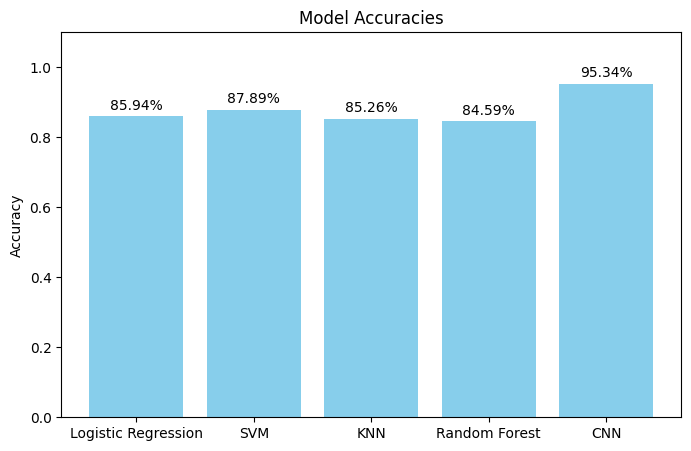

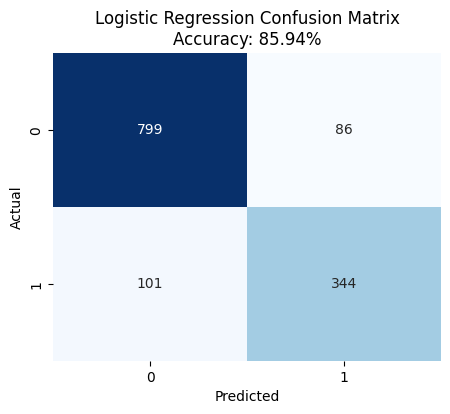

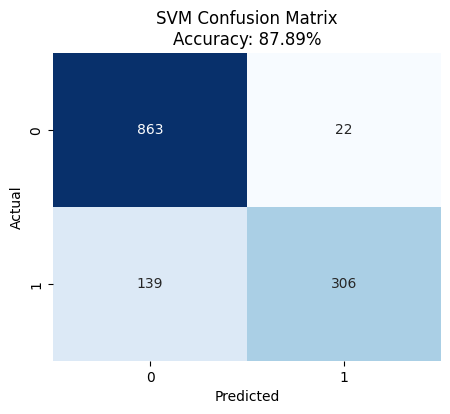

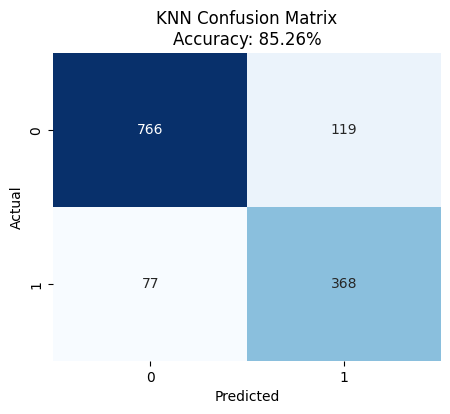

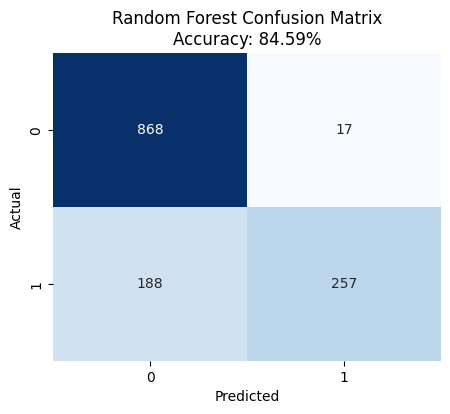

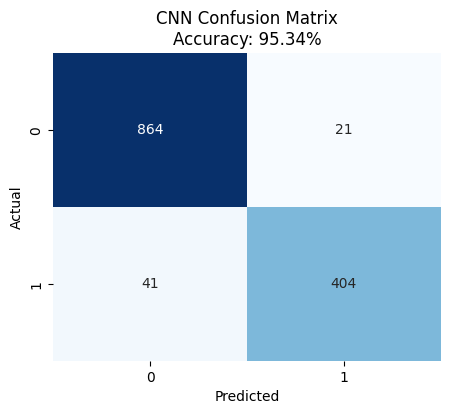

In [15]:
# --- Accuracy Bar Chart with Values ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
bars = plt.bar(acc_dict.keys(), acc_dict.values(), color='skyblue')

# Add accuracy value on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height*100:.2f}%',
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.1)  # Extend y-axis a bit above 1
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.show()

# --- Plot Confusion Matrices for all models ---
for name, cm in cm_dict.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix\nAccuracy: {acc_dict[name]*100:.2f}%")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


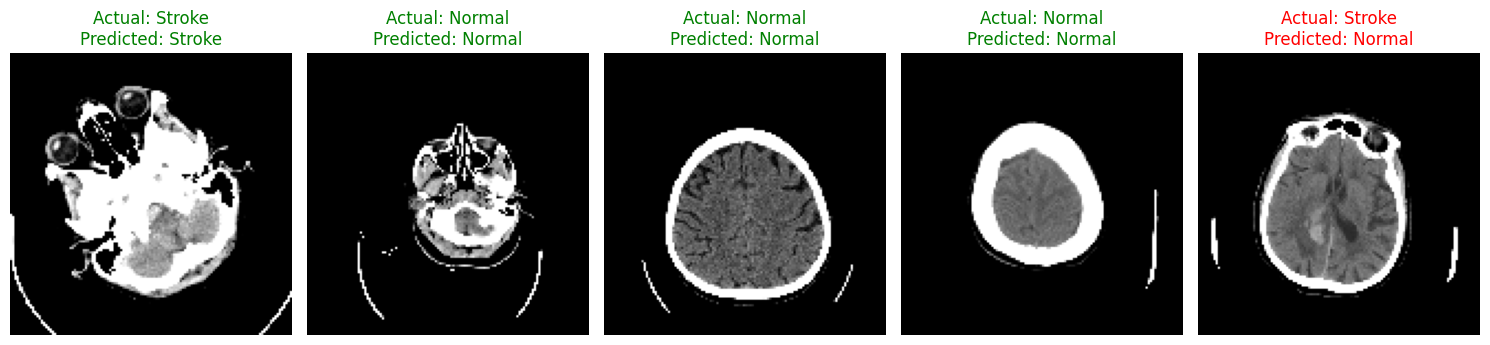

In [16]:
import matplotlib.pyplot as plt
import random

# === Test random images ===
num_samples = 5  # number of random images to test
plt.figure(figsize=(15, 8))

for i in range(num_samples):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    actual_label = le.inverse_transform([y_test[idx]])[0]

    # Predict
    pred_prob = cnn.predict(np.expand_dims(img, axis=0))[0][0]
    pred_label = "Stroke" if pred_prob > 0.5 else "Normal"

    # Display
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}", color='green' if actual_label==pred_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Multi class classification

In [1]:
# === Imports ===
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# === Dataset path ===
dataset_path = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset"

# === Load images ===
data = []
labels = []

# Keep all three classes
class_map = {'Normal': 'Normal', 'Ischemia': 'Ischemia', 'Bleeding': 'Bleeding'}

for cls_folder, label in class_map.items():
    folder_path = os.path.join(dataset_path, cls_folder, 'PNG')
    for file in os.listdir(folder_path):
        if file.endswith('.png'):
            img_path = os.path.join(folder_path, file)
            img = load_img(img_path, target_size=(128,128))
            arr = img_to_array(img) / 255.0
            data.append(arr)
            labels.append(label)

print("Total images loaded:", len(data))

# Convert to numpy arrays
X = np.array(data)
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)   # 0=Bleeding, 1=Ischemia, 2=Normal (order may vary)
y_cat = to_categorical(y_enc)  # One-hot for CNN

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_enc
)

# === Classical ML requires flat features ===
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert one-hot labels back to single integer labels for classical ML
y_train_cls = np.argmax(y_train, axis=1)
y_test_cls = np.argmax(y_test, axis=1)

# --- Train classical ML models ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier()
}

acc_dict = {}
cm_dict = {}

for name, model in models.items():
    model.fit(X_train_flat, y_train_cls)
    y_pred = model.predict(X_test_flat)
    acc = accuracy_score(y_test_cls, y_pred)
    acc_dict[name] = acc
    cm_dict[name] = confusion_matrix(y_test_cls, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

# --- CNN Model ---
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes now
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=10, batch_size=32, verbose=1)

# --- CNN Evaluation ---
cnn_acc = cnn.evaluate(X_test, y_test, verbose=0)[1]
acc_dict['CNN'] = cnn_acc

y_pred_cnn = cnn.predict(X_test)
y_pred_cnn_cls = np.argmax(y_pred_cnn, axis=1)
y_test_cls_true = np.argmax(y_test, axis=1)

cm_dict['CNN'] = confusion_matrix(y_test_cls_true, y_pred_cnn_cls)
print(f"CNN Accuracy: {cnn_acc*100:.2f}%")


Total images loaded: 6650
Logistic Regression Accuracy: 0.8444
SVM Accuracy: 0.8316
KNN Accuracy: 0.8421
Random Forest Accuracy: 0.8075


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 130s 768ms/step - accuracy: 0.6422 - loss: 1.0712 - val_accuracy: 0.7414 - val_loss: 0.6212
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 125s 747ms/step - accuracy: 0.7723 - loss: 0.5499 - val_accuracy: 0.8421 - val_loss: 0.4618
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 140s 735ms/step - accuracy: 0.8536 - loss: 0.3755 - val_accuracy: 0.8835 - val_loss: 0.3525
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 147s 764ms/step - accuracy: 0.9153 - loss: 0.2490 - val_accuracy: 0.9038 - val_loss: 0.3379
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 125s 750ms/step - accuracy: 0.9414 - loss: 0.1699 - val_accuracy: 0.9226 - val_loss: 0.2786
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 126s 758ms/step - accuracy: 0.9589 - loss: 0.1186 - val_accuracy: 0.9293 - val_loss: 0.2944
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 127s 761ms/step - accuracy: 0.9649 - loss: 0.0972 - val_accuracy: 0.9188 - val_loss: 0.3247
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 127s 760ms/step - accuracy: 0.9686 -

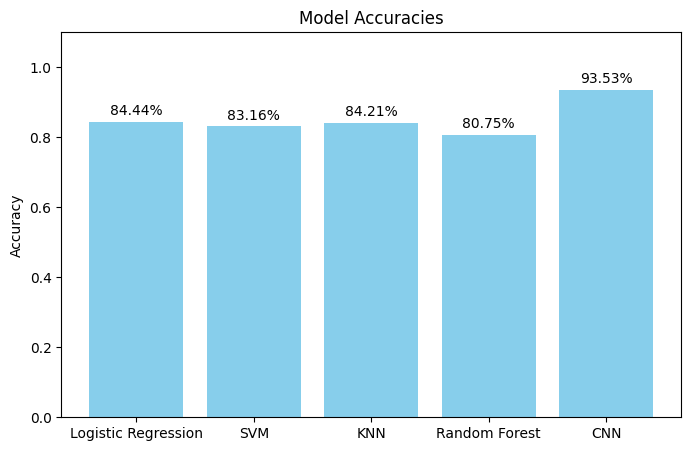

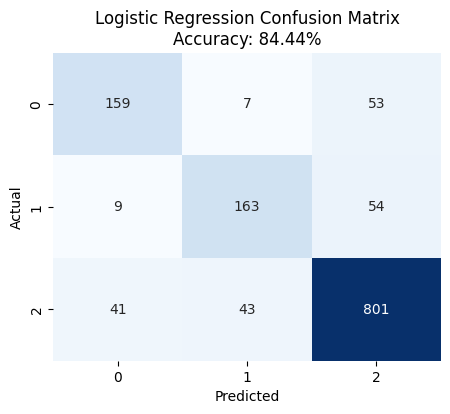

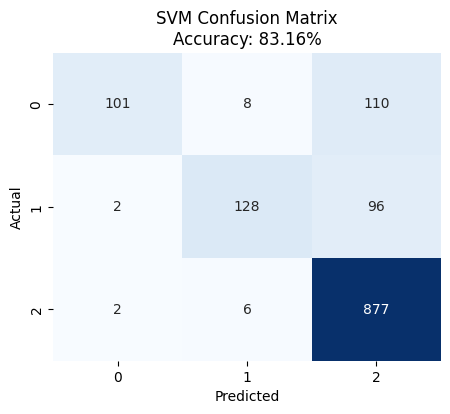

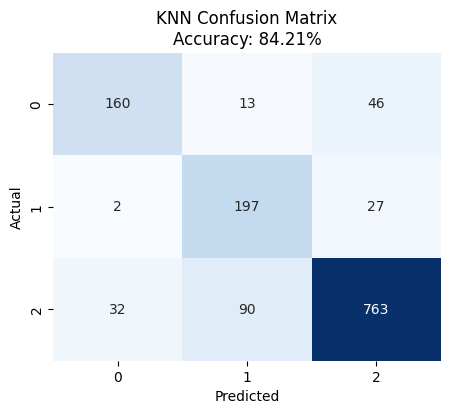

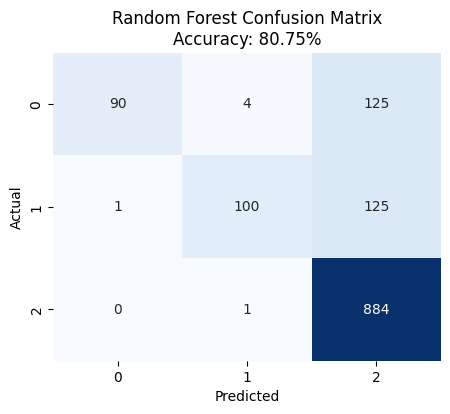

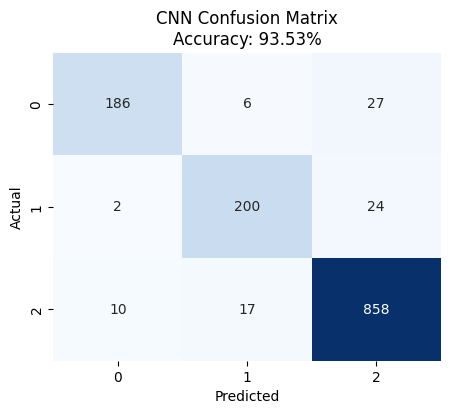

In [2]:
# --- Accuracy Bar Chart with Values ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
bars = plt.bar(acc_dict.keys(), acc_dict.values(), color='skyblue')

# Add accuracy value on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height*100:.2f}%',
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.1)  # Extend y-axis a bit above 1
plt.ylabel("Accuracy")
plt.title("Model Accuracies")
plt.show()

# --- Plot Confusion Matrices for all models ---
for name, cm in cm_dict.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix\nAccuracy: {acc_dict[name]*100:.2f}%")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


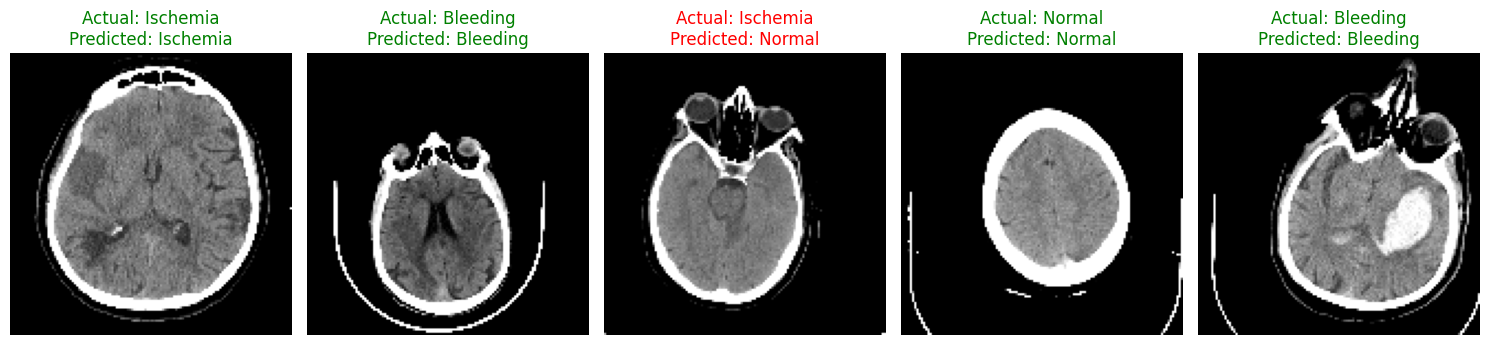

In [10]:
import matplotlib.pyplot as plt
import random
import numpy as np

# === Test random images ===
num_samples = 5  # number of random images to test
plt.figure(figsize=(15, 8))

# Convert one-hot encoded y_test back to single integer labels
y_test_cls = np.argmax(y_test, axis=1)

for i in range(num_samples):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]

    # 🟢 Use the original label (Normal / Ischemia / Bleeding) by inverse transforming the integer label
    actual_label = le.inverse_transform([y_test_cls[idx]])[0]

    # 🧠 Predict (3 classes: Normal, Ischemia, Bleeding)
    pred_probs = cnn.predict(np.expand_dims(img, axis=0))[0]
    pred_class_idx = np.argmax(pred_probs)
    pred_label = le.inverse_transform([pred_class_idx])[0]


    # ✅ Determine if prediction matches actual (for color)
    title_color = 'green' if actual_label == pred_label else 'red'

    # 🎨 Display image and predictions
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()